# NYC Taxi Tip Percent Prediction


#### Done By
##### Ronak Sankaranarayanan
##### Sitanshu Rupani
##### Sidhi Patil
##### Janani Sankarasubramanian

**Required Readings:** 
* [Analyzing 1.1 Billion NYC Taxi and Uber Trips](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/) 
* Please download the NYC taxi and Uber dataset from [here](https://github.com/toddwschneider/nyc-taxi-data).






The advent of COVID-19 has hit the world economy really hard. Worst hit, are the travel and service sectors which depend on human contact. Taxi drivers are unfortunately at the intersection of the service and travel sectors. They're entire livelihoods almost ceased to exist overnight once harsh lockdowns were imposed throughout the world. Their fares and rides were brought down to near zero levels since people stopped going out of their homes for work, etc due to the fear of the virus.
<br>
<br>
We, in this study want to examine ride behaviour in the first six monts of 2020. Our end goal is to build a model that predicts how much a customer will tip their driver after a trip.<br>
We decided to choose this topic due to the importance of tips in the taxi drivers earnings. Tips form a large part of a drivers revenue stream since most of the taxi fare actually goes to the taxi company. If we can model customer behaviour which leads to higher tips for the drivers, we can help improve their lives in these tough times 
<br>
<br>
For this project we have decided to use the data from the Green Taxi Company in the months between January to June of 2020


















# Data Collection/Processing: 

In [6]:
# To Access New York TAXI/UBER Dataset via SODA API
# import sys
# install sodapy
# !{sys.executable} -m pip install sodapy

# install shapefile
# !{sys.executable} -m pip install pyshp

#!{sys.executable} -m pip install shapely

#!{sys.executable} -m pip install plotly

In [23]:
#import libraries
from sodapy import Socrata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline

#setting columns to display 
pd.set_option('display.max_columns', None)

In [3]:
# creating unauthenticated client (only works with public data sets)
client = Socrata("data.cityofnewyork.us", None)

In [4]:
#2020 Green Taxi Trip Data 
green_taxis = client.get_all("pkmi-4kfn", where="lpep_pickup_datetime>'2020-01-01'and lpep_pickup_datetime<'2020-06-30'") # considering only week
#green_taxis = client.get("q5mz-t52e", limit=5000)
                 
# Convert to pandas DataFrame
green_taxis_df = pd.DataFrame.from_records(green_taxis)

In [7]:
# dimensions
green_taxis_df.shape #ehail_fee column not there

(1223434, 19)

In [8]:
green_taxis_df.head()

,congestion_surcharge,dolocationid,extra,fare_amount,improvement_surcharge,lpep_dropoff_datetime,lpep_pickup_datetime,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,trip_type,vendorid
0,2.75,237,0.5,18,0.3,2020-01-01T00:19:30.000,2020-01-01T00:00:07.000,0.5,1,1,255,1,N,4.41,0,26.46,5.07,1,2
1,0,39,0.5,10,0.3,2020-01-01T00:10:19.000,2020-01-01T00:00:21.000,0.5,1,2,89,1,N,0,0,11.3,2.30,1,1
2,0,70,0.5,9.5,0.3,2020-01-01T00:07:06.000,2020-01-01T00:00:44.000,0.5,1,2,129,1,N,0,0,10.8,2.71,1,2
3,0,74,0.5,6,0.3,2020-01-01T00:04:49.000,2020-01-01T00:01:04.000,0.5,1,1,75,1,N,1.46,0,8.76,1.35,1,2
4,2.75,238,3.25,11,0.3,2020-01-01T00:13:32.000,2020-01-01T00:01:11.000,0.5,1,1,74,1,N,3,0,18.05,2.50,1,1


In [9]:
green_taxis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223434 entries, 0 to 1223433
Data columns (total 19 columns):
congestion_surcharge     918525 non-null object
dolocationid             1223434 non-null object
extra                    1223434 non-null object
fare_amount              1223434 non-null object
improvement_surcharge    1223434 non-null object
lpep_dropoff_datetime    1223434 non-null object
lpep_pickup_datetime     1223434 non-null object
mta_tax                  1223434 non-null object
passenger_count          918525 non-null object
payment_type             918525 non-null object
pulocationid             1223434 non-null object
ratecodeid               918525 non-null object
store_and_fwd_flag       918525 non-null object
tip_amount               1223434 non-null object
tolls_amount             1223434 non-null object
total_amount             1223434 non-null object
trip_distance            1223434 non-null object
trip_type                918522 non-null object
vendorid   

In [10]:
# Checking for Null Values
green_taxis_df.isnull().sum()

congestion_surcharge     304909
dolocationid                  0
extra                         0
fare_amount                   0
improvement_surcharge         0
lpep_dropoff_datetime         0
lpep_pickup_datetime          0
mta_tax                       0
passenger_count          304909
payment_type             304909
pulocationid                  0
ratecodeid               304909
store_and_fwd_flag       304909
tip_amount                    0
tolls_amount                  0
total_amount                  0
trip_distance                 0
trip_type                304912
vendorid                 304909
dtype: int64

In [11]:
# creating copy to carry out data processing
green_taxis_processed = green_taxis_df.copy()

In [12]:
# converting to date time format
green_taxis_processed["lpep_dropoff_datetime"] = pd.to_datetime(green_taxis_processed["lpep_dropoff_datetime"])
green_taxis_processed["lpep_pickup_datetime"] = pd.to_datetime(green_taxis_processed["lpep_pickup_datetime"])

In [13]:
# computing trip time in minutes
green_taxis_processed['trip_time'] = (green_taxis_processed["lpep_dropoff_datetime"] - green_taxis_processed["lpep_pickup_datetime"]).dt.seconds / 60

In [14]:
# adding separate columns for pickup date, hour and day 
green_taxis_processed['pickup_Date'] = pd.to_datetime(green_taxis_processed['lpep_pickup_datetime']).dt.date
green_taxis_processed['pickup_hour'] = pd.to_datetime(green_taxis_processed['lpep_pickup_datetime']).dt.hour
green_taxis_processed['pickup_Day'] = pd.to_datetime(green_taxis_processed['pickup_Date']).dt.day_name()
green_taxis_processed['pickup_Day_srno'] = pd.to_datetime(green_taxis_processed['pickup_Date']).dt.dayofweek
#green_taxis_processed.drop("lpep_pickup_datetime",axis=1,inplace=True)

In [15]:
# Removing NA Values
green_taxis_processed = green_taxis_processed.dropna()
# converting datatype
green_taxis_processed["ratecodeid"] = green_taxis_processed["ratecodeid"].astype(int)    #nan can't convert to int       
green_taxis_processed["pulocationid"] = green_taxis_processed["pulocationid"].astype(int)        
green_taxis_processed["dolocationid"] = green_taxis_processed["dolocationid"].astype(int)        
green_taxis_processed["passenger_count"] = green_taxis_processed["passenger_count"].astype(int)  
green_taxis_processed["payment_type"] = green_taxis_processed["payment_type"].astype(int)         
green_taxis_processed["trip_type"] = green_taxis_processed["trip_type"].astype(int) 
green_taxis_processed["vendorid"] = green_taxis_processed["vendorid"].astype(int)             

green_taxis_processed["trip_distance"] = green_taxis_processed["trip_distance"].astype(float)        
green_taxis_processed["extra"] = green_taxis_processed["extra"].astype(float)                
green_taxis_processed["fare_amount"] = green_taxis_processed["fare_amount"].astype(float)          
green_taxis_processed["mta_tax"] = green_taxis_processed["mta_tax"].astype(float)              
green_taxis_processed["tip_amount"] = green_taxis_processed["tip_amount"].astype(float)            
green_taxis_processed["tolls_amount"] = green_taxis_processed["tolls_amount"].astype(float)          
green_taxis_processed["total_amount"] = green_taxis_processed["total_amount"].astype(float)          
green_taxis_processed["improvement_surcharge"] = green_taxis_processed["improvement_surcharge"].astype(float) 

In [16]:
# Removing negative values
green_taxis_processed = green_taxis_processed[green_taxis_processed['fare_amount'] > 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['trip_distance'] > 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['extra'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['mta_tax'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['tip_amount'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['tolls_amount'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['improvement_surcharge'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['total_amount'] >= 0]
green_taxis_processed = green_taxis_processed[green_taxis_processed['trip_time'] > 0]
# Removing the 99 Outlier
green_taxis_processed = green_taxis_processed[green_taxis_processed['ratecodeid'] != 99.0]
# Replacing 0 Passenger Count
green_taxis_processed['passenger_count'][green_taxis_processed['passenger_count'] == 0] = 1


C:\Users\Ronak\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# Creating Avg Speed Column
green_taxis_processed['speed'] = green_taxis_processed['trip_distance'] / green_taxis_processed['trip_time'] * 60
# computing tip percentage
green_taxis_processed['tip_percentage'] = 100*green_taxis_processed.tip_amount/green_taxis_processed.fare_amount

green_taxis_processed = green_taxis_processed[green_taxis_processed['tip_percentage'] < 100]

In [18]:
# Creating Classes for Tip Percentage
green_taxis_processed.loc[(green_taxis_processed['tip_percentage'] == 0), 'TipBand'] = 0
green_taxis_processed.loc[(green_taxis_processed['tip_percentage'] > 0) & (green_taxis_processed['tip_percentage'] <= 30), 'TipBand'] = 1
green_taxis_processed.loc[(green_taxis_processed['tip_percentage'] > 30) & (green_taxis_processed['tip_percentage'] <= 50), 'TipBand'] = 2
green_taxis_processed.loc[(green_taxis_processed['tip_percentage'] > 50), 'TipBand'] = 3

In [19]:
green_taxis_processed.head()

,congestion_surcharge,dolocationid,extra,fare_amount,improvement_surcharge,lpep_dropoff_datetime,lpep_pickup_datetime,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,trip_type,vendorid,trip_time,pickup_Date,pickup_hour,pickup_Day,pickup_Day_srno,speed,tip_percentage,TipBand
0,2.75,237,0.50,18.0,0.3,2020-01-01 00:19:30,2020-01-01 00:00:07,0.5,1,1,255,1,N,4.41,0.0,26.46,5.07,1,2,19.383333,2020-01-01,0,Wednesday,2,15.693895,24.500000,1.0
1,0,39,0.50,10.0,0.3,2020-01-01 00:10:19,2020-01-01 00:00:21,0.5,1,2,89,1,N,0.00,0.0,11.30,2.30,1,1,9.966667,2020-01-01,0,Wednesday,2,13.846154,0.000000,0.0
2,0,70,0.50,9.5,0.3,2020-01-01 00:07:06,2020-01-01 00:00:44,0.5,1,2,129,1,N,0.00,0.0,10.80,2.71,1,2,6.366667,2020-01-01,0,Wednesday,2,25.539267,0.000000,0.0
3,0,74,0.50,6.0,0.3,2020-01-01 00:04:49,2020-01-01 00:01:04,0.5,1,1,75,1,N,1.46,0.0,8.76,1.35,1,2,3.750000,2020-01-01,0,Wednesday,2,21.600000,24.333333,1.0
4,2.75,238,3.25,11.0,0.3,2020-01-01 00:13:32,2020-01-01 00:01:11,0.5,1,1,74,1,N,3.00,0.0,18.05,2.50,1,1,12.350000,2020-01-01,0,Wednesday,2,12.145749,27.272727,1.0


In [20]:
green_taxis_processed.describe()

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,trip_distance,trip_type,vendorid,trip_time,pickup_hour,pickup_Day_srno,speed,tip_percentage,TipBand
count,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000,871309.000000
mean,128.994970,0.413473,12.030630,0.298778,0.490866,1.306354,1.467430,101.849770,1.077256,1.216913,0.152416,15.045231,3.001794,1.017607,1.858243,18.499272,14.036359,3.007532,14.956844,10.689046,0.532936
std,76.427099,0.598402,10.263009,0.019107,0.067515,0.959022,0.510409,68.034988,0.542847,1.888155,1.033019,11.829434,144.634824,0.131518,0.348801,87.861795,5.694752,1.913312,726.699593,13.126335,0.642284
min,1.000000,0.000000,0.010000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.010000,0.010000,1.000000,1.000000,0.016667,0.000000,0.000000,0.000417,0.000000,0.000000
25%,65.000000,0.000000,6.500000,0.300000,0.500000,1.000000,1.000000,49.000000,1.000000,0.000000,0.000000,8.160000,1.020000,1.000000,2.000000,6.150000,10.000000,1.000000,8.807339,0.000000,0.000000
50%,129.000000,0.000000,9.000000,0.300000,0.500000,1.000000,1.000000,75.000000,1.000000,0.000000,0.000000,11.300000,1.730000,1.000000,2.000000,10.016667,15.000000,3.000000,11.066667,0.000000,0.000000
75%,193.000000,0.500000,14.000000,0.300000,0.500000,1.000000,2.000000,134.000000,1.000000,2.000000,0.000000,17.560000,3.220000,1.000000,2.000000,15.983333,18.000000,5.000000,14.359833,22.679245,1.000000
max,265.000000,14.260000,753.000000,0.300000,3.550000,9.000000,5.000000,265.000000,6.000000,90.090000,96.120000,753.800000,134121.500000,2.000000,2.000000,1439.966667,23.000000,6.000000,669677.392510,99.047619,3.000000


# Data Exploration: Exploring the Uber/Taxi Dataset
**Plotting Pickup locations for 5000 uber trips in a scatter plot**

In [24]:
# Importing Uber Ride Data for the months of Jan - Jun 2020
uber_data_jan = pd.read_csv('fhvhv_tripdata_2020-01.csv')
uber_data_feb = pd.read_csv('fhvhv_tripdata_2020-02.csv')
uber_data_mar = pd.read_csv('fhvhv_tripdata_2020-03.csv')
uber_data_apr = pd.read_csv('fhvhv_tripdata_2020-04.csv')
uber_data_may = pd.read_csv('fhvhv_tripdata_2020-05.csv')
uber_data_jun = pd.read_csv('fhvhv_tripdata_2020-06.csv')
data = [uber_data_jan, uber_data_feb, uber_data_mar, uber_data_apr, uber_data_may, uber_data_jun]
uber_data_2020 = pd.concat(data)

#Randomly Sampling 5000 rides
uber_data_2020 = uber_data_2020[['dispatching_base_num','pickup_datetime','PULocationID']]
uber_data_2020 = uber_data_2020.sample(5000, random_state=1)

#Configuring the Shapefile provided in the TLC Website for latitude and longitude mapping
sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
print (shp_dic)

def get_lat_lon(sf):
    lat_lon_data = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        sfRec = sr.record
        loc_id = sfRec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        lat_lon_data.append((loc_id, x, y))
    return pd.DataFrame(lat_lon_data, columns=["LocationID", "longitude", "latitude"])

sfRec = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in sfRec]
location_df = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")

#Merging Latitude and Longitude with base data
uber_data_2020 = uber_data_2020.set_index('PULocationID')
pickup_data = pd.merge(uber_data_2020, location_df, how='inner', left_on = 'PULocationID', right_on = 'LocationID')

{'OBJECTID': 0, 'Shape_Leng': 1, 'Shape_Area': 2, 'zone': 3, 'LocationID': 4, 'borough': 5}


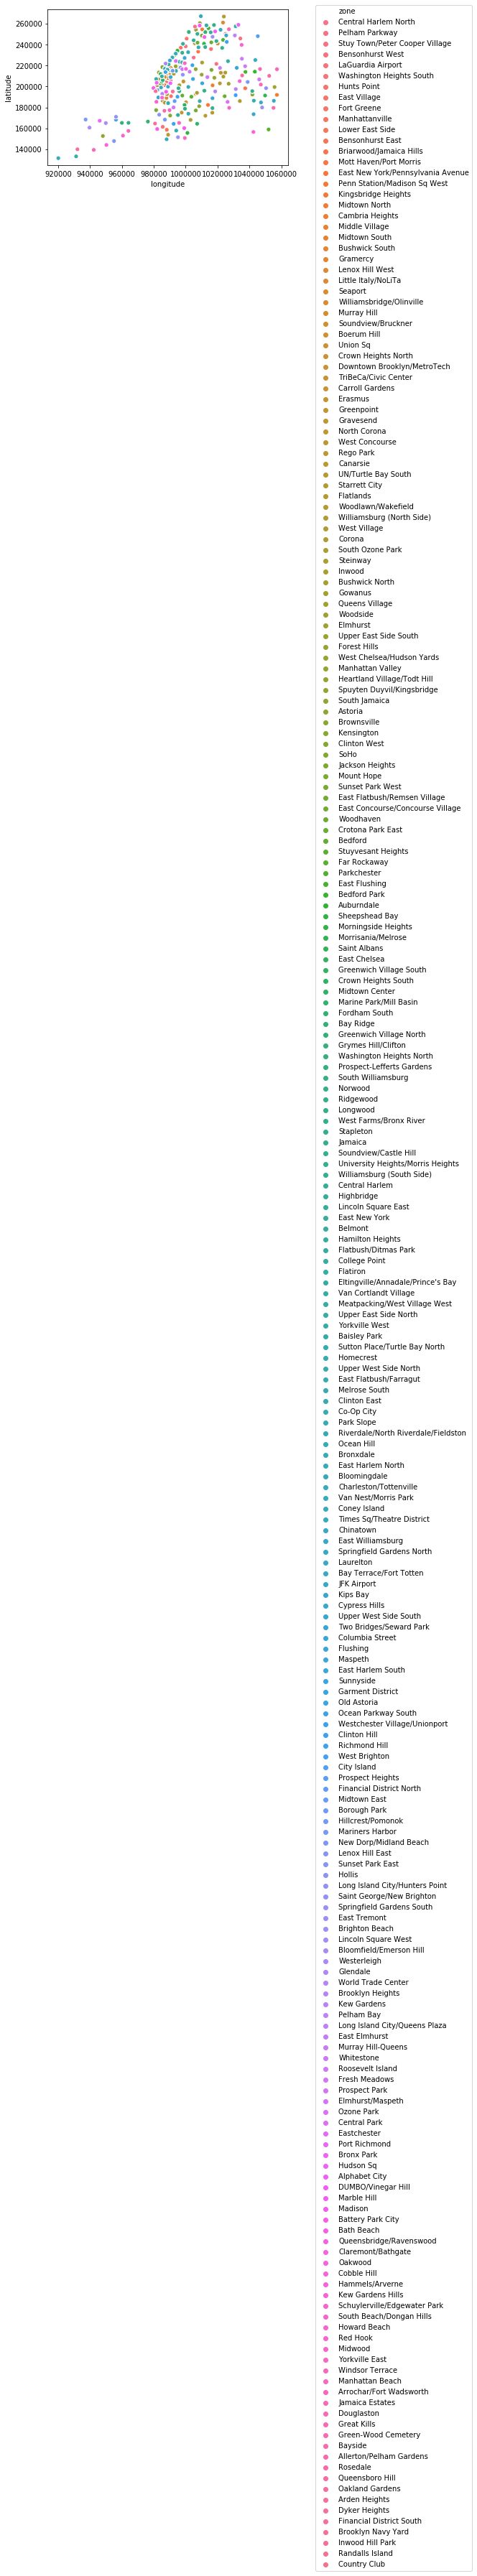

In [26]:
#Scatter plot on Zones
g =sns.scatterplot(x="longitude", y="latitude",
              hue="zone",
              data=pickup_data);

g.legend(bbox_to_anchor=(1.1, 1.05))

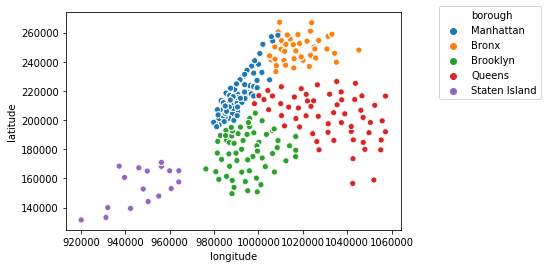

In [27]:
#Scatter plot on Borough
h =sns.scatterplot(x="longitude", y="latitude",
              hue="borough",
              data=pickup_data);

h.legend(bbox_to_anchor=(1.1, 1.05))

## Exploring the Green Taxi Dataset



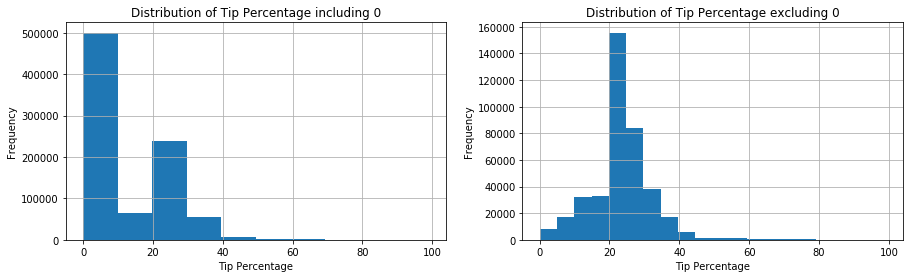

In [28]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 
green_taxis_processed.tip_percentage.hist(ax=ax[0])
ax[0].set_title('Distribution of Tip Percentage including 0')
ax[0].set_xlabel('Tip Percentage')
ax[0].set_ylabel('Frequency')
dff = green_taxis_processed[green_taxis_processed['tip_percentage'] > 0] #focusinf on trips with tips
dff.tip_percentage.hist(bins=20,ax=ax[1])
ax[1].set_title('Distribution of Tip Percentage excluding 0')
ax[1].set_xlabel('Tip Percentage')
ax[1].set_ylabel('Frequency')
plt.show()

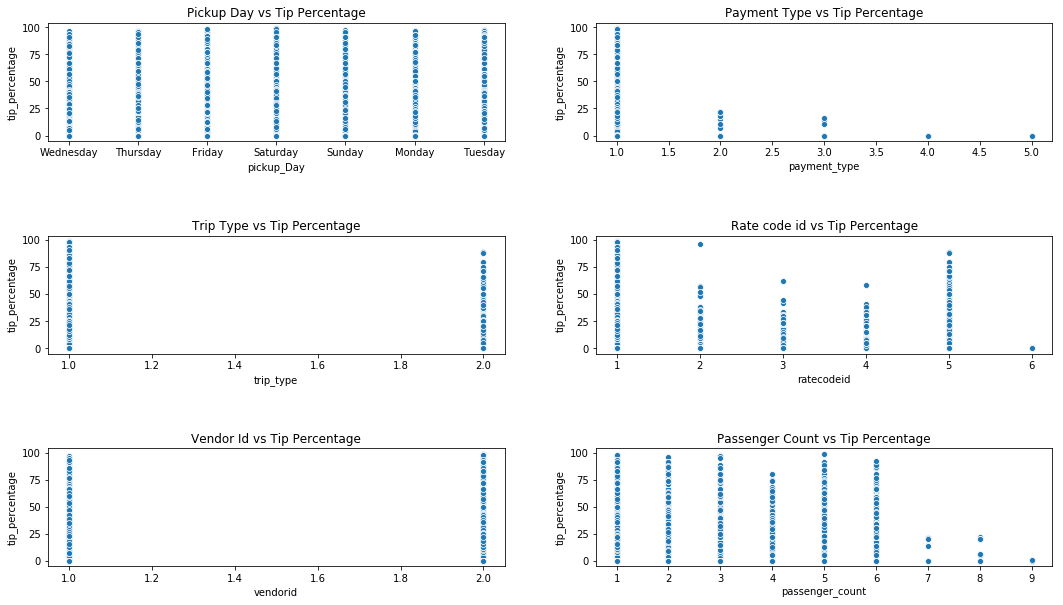

In [29]:
fig, axs = plt.subplots(3,2, figsize=(18,10))
axs[0,0].set_title('Pickup Day vs Tip Percentage')
sns.scatterplot(x= "pickup_Day", y="tip_percentage", data = green_taxis_processed, ax=axs[0,0] )
axs[0,1].set_title('Payment Type vs Tip Percentage')
sns.scatterplot(x = 'payment_type', y = 'tip_percentage', data = green_taxis_processed, ax=axs[0,1])
axs[1,0].set_title('Trip Type vs Tip Percentage')
sns.scatterplot(x = 'trip_type', y = 'tip_percentage', data = green_taxis_processed, ax=axs[1,0])
axs[1,1].set_title('Rate code id vs Tip Percentage')
sns.scatterplot(x = 'ratecodeid', y = 'tip_percentage', data = green_taxis_processed, ax=axs[1,1])
axs[2,0].set_title('Vendor Id vs Tip Percentage')
sns.scatterplot(x = 'vendorid', y = 'tip_percentage', data = green_taxis_processed, ax=axs[2,0])
axs[2,1].set_title('Passenger Count vs Tip Percentage')
sns.scatterplot(x = 'passenger_count', y = 'tip_percentage', data = green_taxis_processed, ax=axs[2,1])
plt.subplots_adjust(hspace = 0.8)

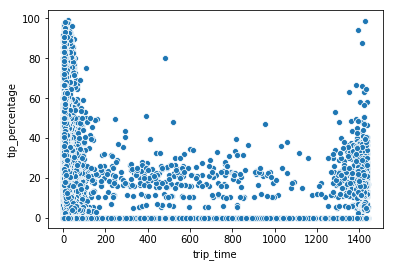

In [30]:
#plotting cab speed vs tip_amount
#plt.scatter(x= green_taxis_processed["trip_distance"]/green_taxis_processed["trip_time"], y=green_taxis_processed["tip_percentage"])

sns.scatterplot(x= green_taxis_processed["trip_time"], y=green_taxis_processed["tip_percentage"])

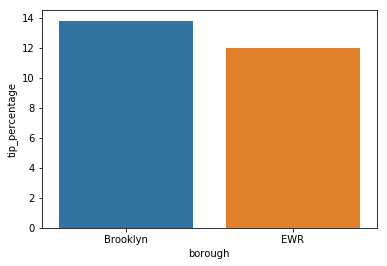

In [57]:
green_taxis_processed_temp = green_taxis_processed.set_index('pulocationid')

green_taxi_pickup = pd.merge(green_taxis_processed_temp, location_df, how='inner', left_on = 'pulocationid', right_on = 'LocationID')

# grouping on Pickup location id
df = green_taxi_pickup.groupby(["borough"])['tip_percentage'].median()
df = df.reset_index()
sns.barplot(x = 'borough', y = 'tip_percentage', data = df[df["tip_percentage"]>0])


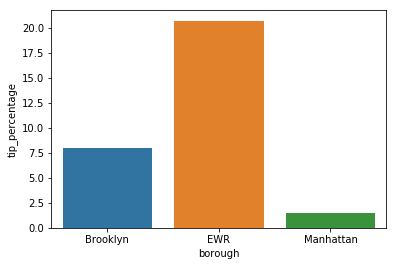

In [58]:
green_taxis_processed_temp = green_taxis_processed.set_index('dolocationid')

green_taxi_dropoff = pd.merge(green_taxis_processed_temp, location_df, how='inner', left_on = 'dolocationid', right_on = 'LocationID')

# grouping on Pickup location id
df = green_taxi_dropoff.groupby(["borough"])['tip_percentage'].median()
df = df.reset_index()
sns.barplot(x = 'borough', y = 'tip_percentage', data = df[df["tip_percentage"]>0])


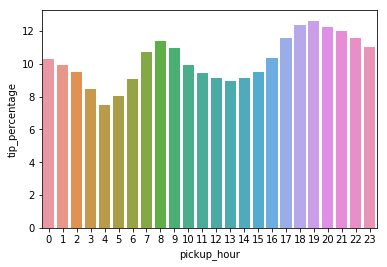

In [32]:
df2 = green_taxis_processed.groupby(["pickup_hour"])['tip_percentage'].mean()
df2 = df2.reset_index()

sns.barplot(x = 'pickup_hour', y = 'tip_percentage', data = df2)

In [33]:
#Final Dataset
final_df = green_taxis_processed.drop(['lpep_pickup_datetime','lpep_pickup_datetime','lpep_dropoff_datetime','store_and_fwd_flag','vendorid','pickup_Date','total_amount'],axis=1)

In [34]:
#Changing to categorical Data
final_df['payment_type'] = pd.Categorical(final_df['payment_type'])
final_df['ratecodeid'] = pd.Categorical(final_df['ratecodeid'])
final_df['trip_type'] = pd.Categorical(final_df['trip_type'])
final_df['pickup_hour'] = pd.Categorical(final_df['pickup_hour'])
final_df['pickup_Day_srno'] = pd.Categorical(final_df['pickup_Day_srno'])
final_df['dolocationid'] = pd.Categorical(final_df['dolocationid'])
final_df['pulocationid'] = pd.Categorical(final_df['pulocationid'])

We are classifying the trip percentage for all records into four groups. To predict a group/label for tip percentage on test data we're using the following four models for training -
1.	Random Forest - It is a classification algorithm consisting of many decision trees. In a random forest, only a random subset of the features is taken into consideration by the algorithm for splitting a node. It is also one of the most used algorithms and gives great results most of the time.
2.	Decision Tree - It's a supervised learning method that can be used for classification. Basically, they are a series of questions designed to assign a classification and are easy to interpret.
3.	K Nearest Neighbor - It works by finding the distances between data points and selects the specified number of data points (K) closest to the test point (unknown label) and then votes for the most frequent label.
4.	Artificial Neural Network (ANN) - In simple words, neural networks are built of simple elements called neurons, which take in a real value, multiply it by weight, and run it through a non-linear activation function.


We are also using Principal Component Analysis(PCA) which is a dimensionality reduction algorithm to projects the original set of features into new space while preserving data structure.


### Model Starts Here

#### Decision Tree

In [35]:
# Training and Testing split
X = final_df.drop(['TipBand', 'pickup_Day', 'tip_percentage','tip_amount','fare_amount'], axis=1)
y = final_df['TipBand']

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)

In [37]:
# Creating Decision Tree classifer object
dct = DecisionTreeClassifier(random_state=0,max_depth=6, criterion = 'entropy')

# Training with Decision Tree Classifer
dct = dct.fit(X_train,y_train)

#Predicting the response for test dataset
dt_pred = dct.predict(X_test)

In [38]:
features = X_train.columns

#### Random Forest

In [39]:
# Performing One Hot Encoder for all the categorical data
final_df = pd.concat([final_df,pd.get_dummies(final_df['payment_type'],prefix='payment_type')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['ratecodeid'],prefix='ratecodeid')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['trip_type'],prefix='trip_type')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['pickup_hour'],prefix='pickup_hour')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['pickup_Day_srno'],prefix='pickup_Day_srno')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['dolocationid'],prefix='dolocationid')],axis=1)
final_df = pd.concat([final_df,pd.get_dummies(final_df['pulocationid'],prefix='pulocationid')],axis=1)
final_df.drop(['payment_type','ratecodeid','trip_type','pickup_hour','pickup_Day_srno','dolocationid','pulocationid'], axis=1,inplace=True)


In [40]:
X = final_df.drop(['TipBand', 'pickup_Day', 'tip_percentage','tip_amount','fare_amount'], axis=1)
y = final_df['TipBand']

In [41]:
#PCA to reduce the Dimensionality
X = PCA(n_components=16).fit_transform(X)

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)

In [43]:
#Random forest classifier
rf = RandomForestClassifier(n_estimators = 10,criterion = 'entropy',random_state=42)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

#### KNN Classifier

In [44]:
#K nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)

#### Artificial Neural Network

In [45]:
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [46]:
y_train = pd.get_dummies(y_train)

In [47]:
dummy_y = pd.get_dummies(y_test)

In [48]:
model.fit(X_train, y_train.values, epochs=25, validation_data=(X_test, dummy_y.values), batch_size=1000, verbose=0)

In [49]:
y_pred_NN = model.predict_classes(X_test)

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


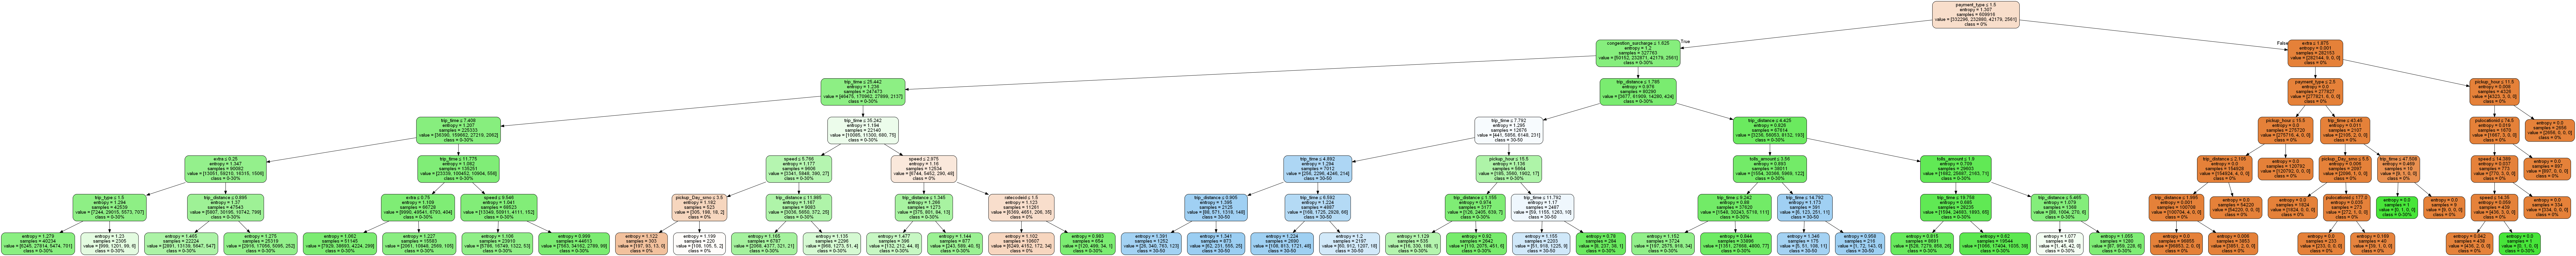

In [51]:
# Decision Tree Data Visualization
target_names = ['0%','0-30%','30-50','50<']
dot_data = StringIO()
export_graphviz(dct, out_file=dot_data, filled=True, rounded=True, special_characters=True,
                feature_names = features, class_names=target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

#### Confusion matrix and Classification Report. 

In [52]:
#Decision Tree : 
print('Decision Tree result')
print('Classification Report',classification_report(y_test, dt_pred, target_names= target_names),sep = '\n')
print('Confusion Matrix',confusion_matrix(y_test, dt_pred),sep = '\n')

Decision Tree result


C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report
              precision    recall  f1-score   support

          0%       0.98      0.87      0.92    142315
       0-30%       0.73      0.97      0.83     99789
       30-50       0.59      0.13      0.22     18225
         50<       0.00      0.00      0.00      1064

    accuracy                           0.85    261393
   macro avg       0.58      0.49      0.49    261393
weighted avg       0.86      0.85      0.84    261393

Confusion Matrix
[[123696  18485    134      0]
 [  1829  96510   1450      0]
 [    84  15698   2443      0]
 [    19    957     88      0]]


In [53]:
print('Random Forest Classifier')
print('Classification Report',classification_report(y_test, rf_pred, target_names= target_names),sep = '\n')
print('Confusion Matrix',confusion_matrix(y_test, rf_pred),sep = '\n')

Random Forest Classifier
Classification Report
              precision    recall  f1-score   support

          0%       0.94      0.90      0.92    142315
       0-30%       0.76      0.89      0.82     99789
       30-50       0.39      0.17      0.24     18225
         50<       0.13      0.02      0.04      1064

    accuracy                           0.84    261393
   macro avg       0.56      0.50      0.50    261393
weighted avg       0.83      0.84      0.83    261393

Confusion Matrix
[[128271  13438    583     23]
 [  6791  88910   3988    100]
 [   936  14195   3057     37]
 [    82    814    144     24]]


In [54]:
print('KNN Classifier')
print('Classification Report',classification_report(y_test, knn_pred, target_names= target_names),sep = '\n')
print('Confusion Matrix',confusion_matrix(y_test, knn_pred),sep = '\n')

KNN Classifier
Classification Report
              precision    recall  f1-score   support

          0%       0.93      0.88      0.90    142315
       0-30%       0.73      0.88      0.80     99789
       30-50       0.40      0.14      0.21     18225
         50<       0.03      0.00      0.00      1064

    accuracy                           0.83    261393
   macro avg       0.52      0.48      0.48    261393
weighted avg       0.81      0.83      0.81    261393

Confusion Matrix
[[125134  16646    532      3]
 [  8259  88309   3199     22]
 [  1255  14362   2601      7]
 [   113    832    118      1]]


In [56]:
print('Artificial Neural Network - ANN')
print('Classification Report',classification_report(y_test, y_pred_NN, target_names= target_names),sep = '\n')
print('Confusion Matrix',confusion_matrix(y_test, y_pred_NN),sep = '\n')

Artificial Neural Network - ANN


C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report
              precision    recall  f1-score   support

          0%       0.99      0.86      0.92    142315
       0-30%       0.73      0.98      0.83     99789
       30-50       0.62      0.09      0.16     18225
         50<       0.00      0.00      0.00      1064

    accuracy                           0.85    261393
   macro avg       0.58      0.48      0.48    261393
weighted avg       0.86      0.85      0.83    261393

Confusion Matrix
[[122752  19451    112      0]
 [  1143  97827    819      0]
 [    40  16522   1663      0]
 [     8    974     82      0]]


C:\Users\Ronak\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

